# Solving Burgers' Equation using DeepXDE (PyTorch Backend)

This notebook demonstrates how to solve the **1D time-dependent Burgers' equation** using **Physics-Informed Neural Networks (PINNs)** with **DeepXDE**.

---

## 1. Problem Statement

We consider the viscous Burgers' equation:

$$
\frac{\partial u}{\partial t} + u \frac{\partial u}{\partial x} = \nu \frac{\partial^2 u}{\partial x^2}, \quad (x,t) \in [-1,1] \times [0,1]
$$

with:

* Initial condition:
  $$
  u(x,0) = -\sin(\pi x)
  $$
* Boundary conditions:
  $$
  u(-1,t) = u(1,t) = 0
  $$

## 2. Import Libraries

In [1]:
import deepxde as dde
import numpy as np
import matplotlib.pyplot as plt

dde.config.set_default_float("float32")
dde.backend.set_default_backend("pytorch")

Using backend: pytorch
Other supported backends: tensorflow.compat.v1, tensorflow, jax, paddle.
paddle supports more examples now and is recommended.


Set the default float type to float32
Setting the default backend to "pytorch". You can change it in the ~/.deepxde/config.json file or export the DDE_BACKEND environment variable. Valid options are: tensorflow.compat.v1, tensorflow, pytorch, jax, paddle (all lowercase)


## 3. Define the PDE

In [2]:
nu = 0.01 / np.pi


def burgers_pde(x, u):
    du_x = dde.grad.jacobian(u, x, i=0, j=0)
    du_t = dde.grad.jacobian(u, x, i=0, j=1)
    d2u_xx = dde.grad.hessian(u, x, i=0, j=0)
    return du_t + u * du_x - nu * d2u_xx


## 4. Geometry and Time Domain

In [3]:

geom = dde.geometry.Interval(-1, 1)
time_domain = dde.geometry.TimeDomain(0, 1)
geomtime = dde.geometry.GeometryXTime(geom, time_domain)


## 5. Initial and Boundary Conditions

In [4]:
bc = dde.icbc.DirichletBC(geomtime, lambda x: 0, lambda x, on_boundary: on_boundary)

ic = dde.icbc.IC(
    geomtime,
    lambda x: -np.sin(np.pi * x[:, 0:1]),
    lambda _, on_initial: on_initial,
)

bcs = [bc, ic]



## 6. Training Data

In [5]:
data = dde.data.TimePDE(
    geomtime,
    burgers_pde,
    bcs,
    num_domain=2000,
    num_boundary=200,
    num_initial=200,
)

## 7. Neural Network Architecture

In [6]:
layer_sizes = [2] + [50] * 4 + [1]
net = dde.nn.FNN(layer_sizes, "tanh", "Glorot normal")

## 8. Model Compilation and Training

In [7]:
model = dde.Model(data, net)
model.compile("adam", lr=1e-3)
losshistory, train_state = model.train(epochs=10000)

Compiling model...
'compile' took 0.898479 s

Training model...

Step      Train loss                        Test loss                         Test metric
0         [7.15e-03, 8.20e-02, 7.32e-01]    [7.15e-03, 8.20e-02, 7.32e-01]    []  
1000      [3.20e-02, 1.64e-04, 4.20e-02]    [3.20e-02, 1.64e-04, 4.20e-02]    []  
2000      [1.03e-02, 7.56e-05, 7.97e-03]    [1.03e-02, 7.56e-05, 7.97e-03]    []  
3000      [2.09e-03, 1.07e-05, 1.58e-03]    [2.09e-03, 1.07e-05, 1.58e-03]    []  
4000      [2.09e-03, 8.93e-06, 9.39e-04]    [2.09e-03, 8.93e-06, 9.39e-04]    []  
5000      [8.49e-04, 7.38e-06, 5.90e-04]    [8.49e-04, 7.38e-06, 5.90e-04]    []  
6000      [8.06e-04, 6.30e-06, 4.07e-04]    [8.06e-04, 6.30e-06, 4.07e-04]    []  
7000      [5.90e-04, 2.58e-06, 2.97e-04]    [5.90e-04, 2.58e-06, 2.97e-04]    []  
8000      [2.63e-04, 1.27e-06, 1.84e-04]    [2.63e-04, 1.27e-06, 1.84e-04]    []  
9000      [5.10e-04, 2.44e-06, 1.48e-04]    [5.10e-04, 2.44e-06, 1.48e-04]    []  
10000     [3.48

## 9. Visualization of Results



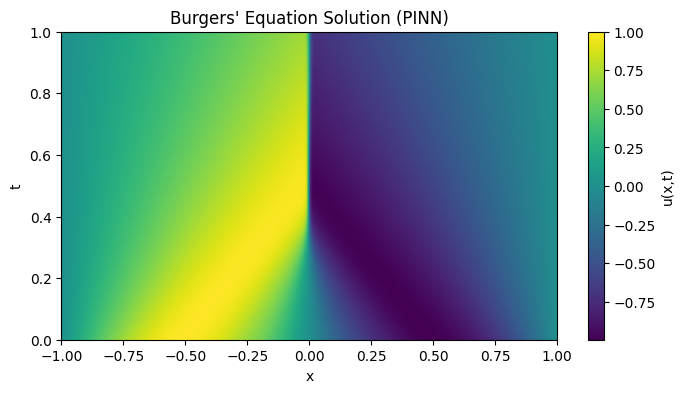

In [8]:
x = np.linspace(-1, 1, 256)
t = np.linspace(0, 1, 100)
X, T = np.meshgrid(x, t)
XT = np.hstack((X.flatten()[:, None], T.flatten()[:, None]))

u_pred = model.predict(XT).reshape(T.shape)

plt.figure(figsize=(8, 4))
plt.imshow(u_pred, extent=[-1, 1, 0, 1], origin='lower', aspect='auto')
plt.colorbar(label='u(x,t)')
plt.xlabel('x')
plt.ylabel('t')
plt.title("Burgers' Equation Solution (PINN)")
plt.show()


## 11. Exercise

1. Reduce viscosity $\nu$ and explain the observation
2. Increase/decrease network depth

---

**This notebook works in VS Code Jupyter and Google Colab.**
